In [1]:
import warnings
from typing import Any, Dict, Tuple

import time

import pandas as pd
import numpy as np

from nltk import casual_tokenize

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from torch.nn import functional as F

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [2]:
DATASET_PATH = "../data/stemming_post_texts.csv"
N_SAMPLES = 10000

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [4]:
dataset = pd.read_csv(DATASET_PATH)
dataset.head()

,text,sentiment
0,украин эт част рус искусствен отделен котор ру...,negative
1,говор относительн небольш коррупц образован ст...,negative
2,сво поляк сдела русск понятн литовск поляк так...,neutral
3,фильм зрител люб диковин соседк пят месяц узна...,neutral
4,государств плат посмотр денежн поток пенсион ф...,negative


In [5]:
if N_SAMPLES > 0:
    dataset = dataset.sample(N_SAMPLES)

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataset.sentiment)

In [80]:
count_vectorizer = CountVectorizer(tokenizer=casual_tokenize, max_features=512)
X = count_vectorizer.fit_transform(dataset.text)

In [81]:
X = np.array(X.toarray())
y = np.array(y).astype(np.int64)
print(f"Shape: X={X.shape}, y={y.shape}")

Shape: X=(10000, 512), y=(10000,)


In [82]:
X_train = X[: int(0.8 * len(X))]
y_train = y[: int(0.8 * len(y))]
X_test = X[int(0.8 * len(X)):]
y_test = y[int(0.8 * len(y)):]

X_train = X_train[: int(0.75 * len(X_train))]
y_train = y_train[: int(0.75 * len(y_train))]
X_val = X_train[int(0.75 * len(X_train)):]
y_val = y_train[int(0.75 * len(y_train)):]

print(f"Train shape: X={X_train.shape}, y={y_train.shape}")
print(f"Validation shape: X={X_val.shape}, y={y_val.shape}")
print(f"Test shape: X={X_test.shape}, y={y_test.shape}")

Train shape: X=(6000, 512), y=(6000,)
Validation shape: X=(1500, 512), y=(1500,)
Test shape: X=(2000, 512), y=(2000,)


In [83]:
train_dataset = TensorDataset(
    torch.from_numpy(X_train).to(device),
    F.one_hot(torch.from_numpy(y_train).to(torch.int64)).to(torch.float64).to(device),
)
val_dataset = TensorDataset(
    torch.from_numpy(X_val).to(device),
    F.one_hot(torch.from_numpy(y_val).to(torch.int64)).to(torch.float64).to(device),
)
test_dataset = TensorDataset(
    torch.from_numpy(X_test).to(device),
    F.one_hot(torch.from_numpy(y_test).to(torch.int64)).to(torch.float64).to(device),
)

In [84]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset)

In [85]:
INPUT_DIM = len(count_vectorizer.vocabulary_) + 1
EMBEDDING_DIM = 128
HIDDEN_DIM = 32
OUTPUT_DIM = len(label_encoder.classes_)
DROPOUT = 0.2

In [86]:
def f1_weighted_score(preds: torch.Tensor, labels: torch.Tensor):
    pred_numpy = preds.cpu().detach().numpy()
    labels_numpy = labels.cpu().detach().numpy()
    pred_flatten = np.argmax(pred_numpy, axis=1).flatten()
    labels_flatten = np.argmax(labels_numpy, axis=1).flatten()
    return f1_score(labels_flatten.astype(np.int32), pred_flatten.astype(np.int32), average="weighted")

In [87]:
def train(
        model: torch.nn.Module,
        dataloader: DataLoader,
        optim: optim.Optimizer,
        loss_func: torch.nn.Module,
) -> Tuple[float, float]:
    loss = 0
    accuracy = 0
    model.train()
    for sequence, sentiment in dataloader:
        optim.zero_grad()
        preds = model(sequence.T).squeeze()
        loss_current = loss_func(preds, sentiment)
        accuracy_curr = f1_weighted_score(preds, sentiment)
        loss_current.backward()
        optim.step()
        loss += loss_current.item()
        accuracy += accuracy_curr.item()
    return loss / len(dataloader), accuracy / len(dataloader)

In [88]:
def validate(
        model: torch.nn.Module,
        dataloader: DataLoader,
        loss_func: torch.nn.Module,
) -> Tuple[float, float]:
    loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            preds = model(sequence.T).squeeze()
            loss_current = loss_func(preds, sentiment)
            accuracy_current = f1_weighted_score(preds, sentiment)
            loss += loss_current.item()
            accuracy += accuracy_current.item()
    return loss / len(dataloader), accuracy / len(dataloader)

In [89]:
def training(
        model: torch.nn.Module,
        train_data: DataLoader,
        validate_data: DataLoader,
        optim: optim.Optimizer,
        loss_func: torch.nn.Module,
        num_epochs: int = 10,
) -> Dict[str, Any]:
    best_loss = float('inf')
    history = {
        "train": {
            "loss": [],
            "accuracy": [],
        },
        "valid": {
            "loss": [],
            "accuracy": [],
        }
    }
    for epoch in range(num_epochs):
        print(f"{'=' * 15} Epoch: {epoch + 1} {'=' * 15}")
        time_start = time.time()
        train_loss, train_accuracy = train(model, train_data, optim, loss_func)
        print(f"Train: loss={train_loss:.3f}, accuracy={train_accuracy:.3f}")
        validation_loss, validation_accuracy = validate(model, validate_data, loss_func)
        print(f"Validation: loss={validation_loss:.3f}, accuracy={validation_accuracy:.3f}")
        time_end = time.time()
        time_delta = time_end - time_start
        if validation_loss < best_loss:
            best_loss = validation_loss
        history["train"]["accuracy"].append(train_accuracy)
        history["train"]["loss"].append(train_accuracy)
        history["valid"]["accuracy"].append(validation_accuracy)
        history["valid"]["loss"].append(validation_loss)
        print(f"Time elapsed: {time_delta:.2f} s\n{'=' * 40}")
    return history

In [90]:
def plot_history(history: dict) -> None:
    train = history.get("train")
    valid = history.get("valid")
    plt.title("Loss")
    plt.plot(train.get("loss"), label="train")
    plt.plot(valid.get("loss"), label="valid")
    plt.legend()
    plt.show()
    plt.title("Accuracy")
    plt.plot(train.get("accuracy"), label="train")
    plt.plot(valid.get("accuracy"), label="valid")
    plt.legend()
    plt.show()

In [91]:
torch.cuda.empty_cache()

## RNN

In [92]:
class RNNModel(torch.nn.Module):

    def __init__(
            self,
            input_dim: int,
            embedding_dim: int,
            hidden_dim: int,
            output_dim: int,
            dropout: float,
    ):
        super().__init__()
        self.embeddings = torch.nn.Embedding(input_dim, embedding_dim)
        self.rnn_layer = torch.nn.RNN(embedding_dim, hidden_dim, dropout=dropout)
        self.fully_connected = torch.nn.Linear(hidden_dim, output_dim)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, sequence):
        embedded = self.embeddings(sequence)
        output, hidden = self.rnn_layer(embedded)
        hidden_state = hidden[-1, :, :].squeeze(0)
        result = self.fully_connected(hidden_state)
        return self.sigmoid(result)

In [93]:
simple_rnn = RNNModel(
    input_dim=INPUT_DIM,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout=DROPOUT,
)
simple_rnn = simple_rnn.to(device)
simple_rnn

RNNModel(
  (embeddings): Embedding(513, 128)
  (rnn_layer): RNN(128, 32, dropout=0.2)
  (fully_connected): Linear(in_features=32, out_features=3, bias=True)
  (sigmoid): Sigmoid()
)

In [94]:
optimizer = optim.RMSprop(simple_rnn.parameters(), lr=1e-3)
loss_function = torch.nn.BCEWithLogitsLoss().to(device)

simple_rnn_history = training(
    simple_rnn,
    train_dataloader,
    val_dataloader,
    optimizer,
    loss_function,
)

=============== Epoch: 1 ===============
Train: loss=0.699, accuracy=0.311
Validation: loss=0.694, accuracy=0.354
Time elapsed: 1.62 s
=============== Epoch: 2 ===============
Train: loss=0.694, accuracy=0.337
Validation: loss=0.693, accuracy=0.351
Time elapsed: 1.36 s
=============== Epoch: 3 ===============
Train: loss=0.693, accuracy=0.336
Validation: loss=0.693, accuracy=0.352
Time elapsed: 1.39 s
=============== Epoch: 4 ===============
Train: loss=0.693, accuracy=0.338
Validation: loss=0.693, accuracy=0.354
Time elapsed: 1.42 s
=============== Epoch: 5 ===============
Train: loss=0.693, accuracy=0.337
Validation: loss=0.693, accuracy=0.351
Time elapsed: 1.36 s
=============== Epoch: 6 ===============
Train: loss=0.693, accuracy=0.337
Validation: loss=0.693, accuracy=0.352
Time elapsed: 1.47 s
=============== Epoch: 7 ===============
Train: loss=0.693, accuracy=0.337
Validation: loss=0.693, accuracy=0.352
Time elapsed: 1.48 s
=============== Epoch: 8 ===============
Train: loss=0.

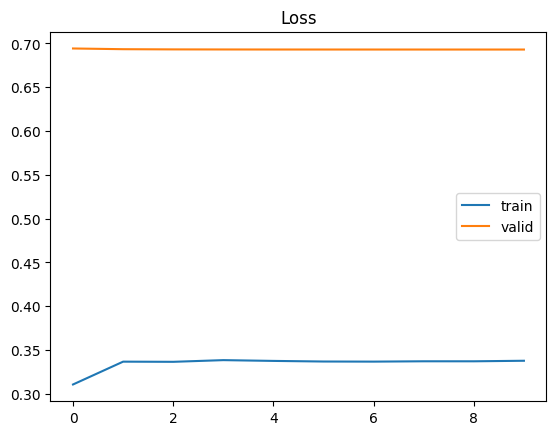

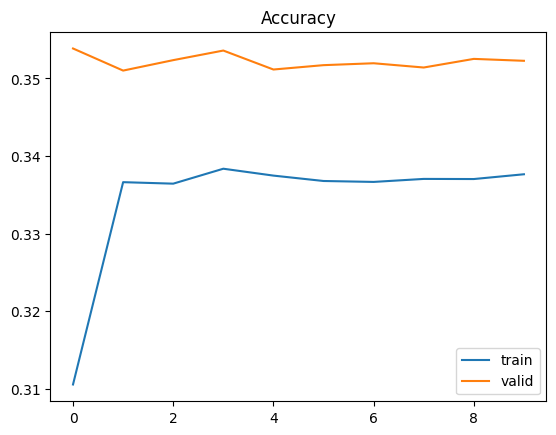

In [95]:
plot_history(simple_rnn_history)

## LSTM

In [190]:
class LSTMModel(torch.nn.Module):

    def __init__(
            self,
            input_dim: int,
            embedding_dim: int,
            hidden_dim: int,
            output_dim: int,
            dropout: float,
            num_lstm_layers: int = 2,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.embeddings = torch.nn.Embedding(input_dim, embedding_dim)
        self.rnn_layer = torch.nn.LSTM(
            embedding_dim,
            hidden_dim,
            dropout=dropout,
            num_layers=num_lstm_layers,
            bidirectional=True,
        )
        fc_input = 2 * hidden_dim
        self.fully_connected = torch.nn.Linear(fc_input, output_dim)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, sequence):
        embedded = self.embeddings(sequence)
        packed_output, (hidden_state, cell_state) = self.rnn_layer(embedded)
        lstm_out = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)
        fc_out = self.fully_connected(lstm_out)
        sigmoid_out = self.sigmoid(fc_out)
        return sigmoid_out


In [191]:
lstm_model = LSTMModel(
    input_dim=INPUT_DIM,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout=DROPOUT,
)
lstm_model = lstm_model.to(device)
lstm_model

LSTMModel(
  (embeddings): Embedding(513, 128)
  (rnn_layer): LSTM(128, 32, num_layers=2, dropout=0.2, bidirectional=True)
  (fully_connected): Linear(in_features=64, out_features=3, bias=True)
  (sigmoid): Sigmoid()
)

In [192]:
optimizer = optim.RMSprop(lstm_model.parameters(), lr=1e-3)
loss_function = torch.nn.BCEWithLogitsLoss().to(device)

lstm_history = training(
    lstm_model,
    train_dataloader,
    val_dataloader,
    optimizer,
    loss_function,
)

=============== Epoch: 1 ===============
Train: loss=0.695, accuracy=0.334
Validation: loss=0.693, accuracy=0.351
Time elapsed: 3.49 s
=============== Epoch: 2 ===============
Train: loss=0.693, accuracy=0.338
Validation: loss=0.693, accuracy=0.350
Time elapsed: 3.40 s
=============== Epoch: 3 ===============
Train: loss=0.693, accuracy=0.336
Validation: loss=0.693, accuracy=0.350
Time elapsed: 2.98 s
=============== Epoch: 4 ===============
Train: loss=0.693, accuracy=0.337
Validation: loss=0.693, accuracy=0.350
Time elapsed: 3.07 s
=============== Epoch: 5 ===============
Train: loss=0.693, accuracy=0.336
Validation: loss=0.693, accuracy=0.350
Time elapsed: 3.02 s
=============== Epoch: 6 ===============
Train: loss=0.693, accuracy=0.336
Validation: loss=0.693, accuracy=0.350
Time elapsed: 3.03 s
=============== Epoch: 7 ===============
Train: loss=0.693, accuracy=0.337
Validation: loss=0.693, accuracy=0.351
Time elapsed: 3.12 s
=============== Epoch: 8 ===============
Train: loss=0.

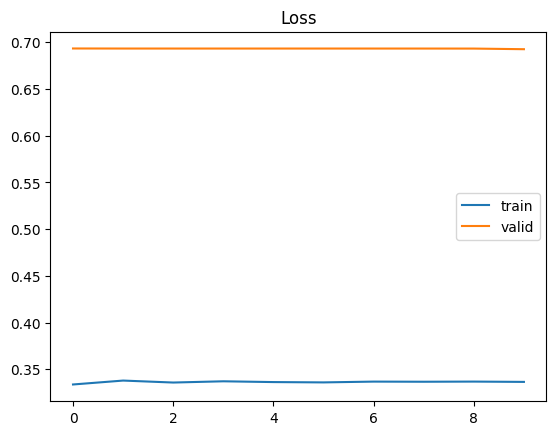

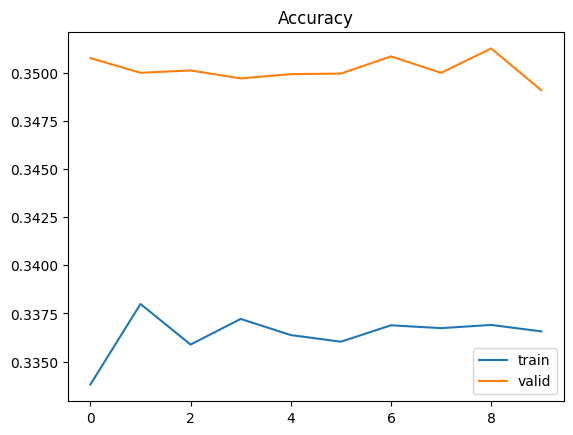

In [193]:
plot_history(lstm_history)

## GRU

In [199]:
class GRUModel(torch.nn.Module):

    def __init__(
            self,
            input_dim: int,
            embedding_dim: int,
            hidden_dim: int,
            output_dim: int,
            dropout: float,
            num_lstm_layers: int = 2,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.embeddings = torch.nn.Embedding(input_dim, embedding_dim)
        self.rnn_layer = torch.nn.GRU(
            embedding_dim,
            hidden_dim,
            dropout=dropout,
            num_layers=num_lstm_layers,
            bidirectional=True,
        )
        fc_input = 2 * hidden_dim
        self.fully_connected = torch.nn.Linear(fc_input, output_dim)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, sequence):
        embedded = self.embeddings(sequence)
        packed_output, hidden_state = self.rnn_layer(embedded)
        lstm_out = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)
        fc_out = self.fully_connected(lstm_out)
        sigmoid_out = self.sigmoid(fc_out)
        return sigmoid_out

In [200]:
gru_model = GRUModel(
    input_dim=INPUT_DIM,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout=DROPOUT,
)
gru_model = gru_model.to(device)
gru_model

GRUModel(
  (embeddings): Embedding(513, 128)
  (rnn_layer): GRU(128, 32, num_layers=2, dropout=0.2, bidirectional=True)
  (fully_connected): Linear(in_features=64, out_features=3, bias=True)
  (sigmoid): Sigmoid()
)

In [201]:
optimizer = optim.RMSprop(gru_model.parameters(), lr=1e-3)
loss_function = torch.nn.BCEWithLogitsLoss().to(device)

lstm_history = training(
    gru_model,
    train_dataloader,
    val_dataloader,
    optimizer,
    loss_function,
)

=============== Epoch: 1 ===============
Train: loss=0.696, accuracy=0.336
Validation: loss=0.693, accuracy=0.349
Time elapsed: 2.68 s
=============== Epoch: 2 ===============
Train: loss=0.693, accuracy=0.337
Validation: loss=0.693, accuracy=0.351
Time elapsed: 2.22 s
=============== Epoch: 3 ===============
Train: loss=0.693, accuracy=0.336
Validation: loss=0.693, accuracy=0.351
Time elapsed: 2.31 s
=============== Epoch: 4 ===============
Train: loss=0.693, accuracy=0.337
Validation: loss=0.693, accuracy=0.351
Time elapsed: 2.55 s
=============== Epoch: 5 ===============
Train: loss=0.693, accuracy=0.336
Validation: loss=0.693, accuracy=0.351
Time elapsed: 2.30 s
=============== Epoch: 6 ===============
Train: loss=0.693, accuracy=0.337
Validation: loss=0.692, accuracy=0.351
Time elapsed: 2.29 s
=============== Epoch: 7 ===============
Train: loss=0.693, accuracy=0.337
Validation: loss=0.692, accuracy=0.351
Time elapsed: 2.41 s
=============== Epoch: 8 ===============
Train: loss=0.

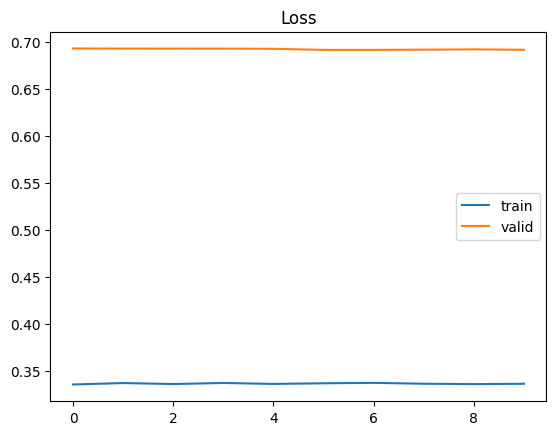

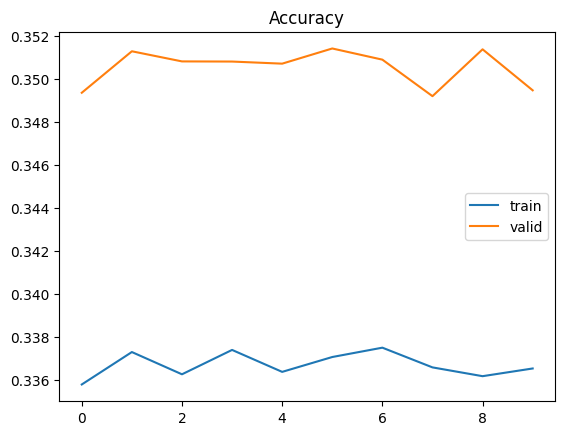

In [202]:
plot_history(lstm_history)